In [1]:
source('packages.r')
#load('/g/scb2/zeller/karcher/dysb_classif/data/siamcat/profiles_merged_with_metadata.rimage')

Warning message:
“replacing previous import ‘vctrs::data_frame’ by ‘tibble::data_frame’ when loading ‘dplyr’”
── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.0     ✔ purrr   0.3.4
✔ tibble  3.0.1     ✔ dplyr   1.0.0
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 3.6.3”
Warning message:
“package ‘stringr’ was built under R version 3.6.3”
── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: mlr

Warning message:
“package ‘mlr’ was built under R version 3.6.3”
Lo

In [2]:
li <- list()
for (file in list.files("/g/scb2/zeller/karcher/rtmp/")) {
    print(file)
    load(str_c("/g/scb2/zeller/karcher/rtmp/", file))
    li[[length(li) + 1]] <- list(sc.obj.train.LOCO, sc.obj.test, sc.obj.train)
    names(li)[length(li)] <- file
}

[1] "ACVD"
[1] "AS"
[1] "BC"
[1] "CRC"
[1] "HTN"
[1] "IBD"
[1] "LCIR"
[1] "MS"
[1] "OB"
[1] "RA"


In [3]:
data_out <- data.frame(test_condition = names(li),
                      LOCO_test_auc = map_dbl(li, function(x) mean(x[[2]]@eval_data$auroc)),
                      LOCO_test_training_cases = map_dbl(li, function(x) sum(x[[1]]@label[[1]] == 1)),
                      LOCO_test_training_controls = map_dbl(li, function(x) sum(x[[1]]@label[[1]] == -1)),                                                  
                      LOCO_test_test_cases = map_dbl(li, function(x) sum(x[[2]]@label[[1]] == 1)),
                      LOCO_test_test_controls = map_dbl(li, function(x) sum(x[[2]]@label[[1]] == -1)),                                                            
                      Within_condition_CV_auc = map_dbl(li, function(x) mean(x[[3]]@eval_data$auroc))) %>%
as_tibble() %>%
mutate(test_condition = pmap_chr(list(test_condition, 
                                      LOCO_test_training_cases, 
                                      LOCO_test_training_controls,
                                      LOCO_test_test_controls,
                                      LOCO_test_test_cases), function(a,b,c,d,e) {
    return(str_c(a," :", b, "/", c, "/", d, "/", e, "/",collapse = "/"))
})) %>%       select(-LOCO_test_training_cases,
                                                       -LOCO_test_training_controls,
                                                       -LOCO_test_test_controls,
                                                       -LOCO_test_test_cases) %>%
                                                 pivot_longer(-test_condition) %>%
                                                 rename(group = name,
                                                       auc = value)

In [313]:
data_out

test_condition,group,auc
<chr>,<chr>,<dbl>
ACVD :2881/1725/171/214/,LOCO_test_auc,0.6896486
ACVD :2881/1725/171/214/,LOCO_CV_auc,0.7937094
AS :2998/1782/114/97/,LOCO_test_auc,0.6701031
AS :2998/1782/114/97/,LOCO_CV_auc,0.9530657
BC :3035/1828/68/60/,LOCO_test_auc,0.6372549
BC :3035/1828/68/60/,LOCO_CV_auc,0.6877451
CRC :2515/1355/541/580/,LOCO_test_auc,0.5665466
CRC :2515/1355/541/580/,LOCO_CV_auc,0.7631238
HTN :2996/1855/41/99/,LOCO_test_auc,0.4661247


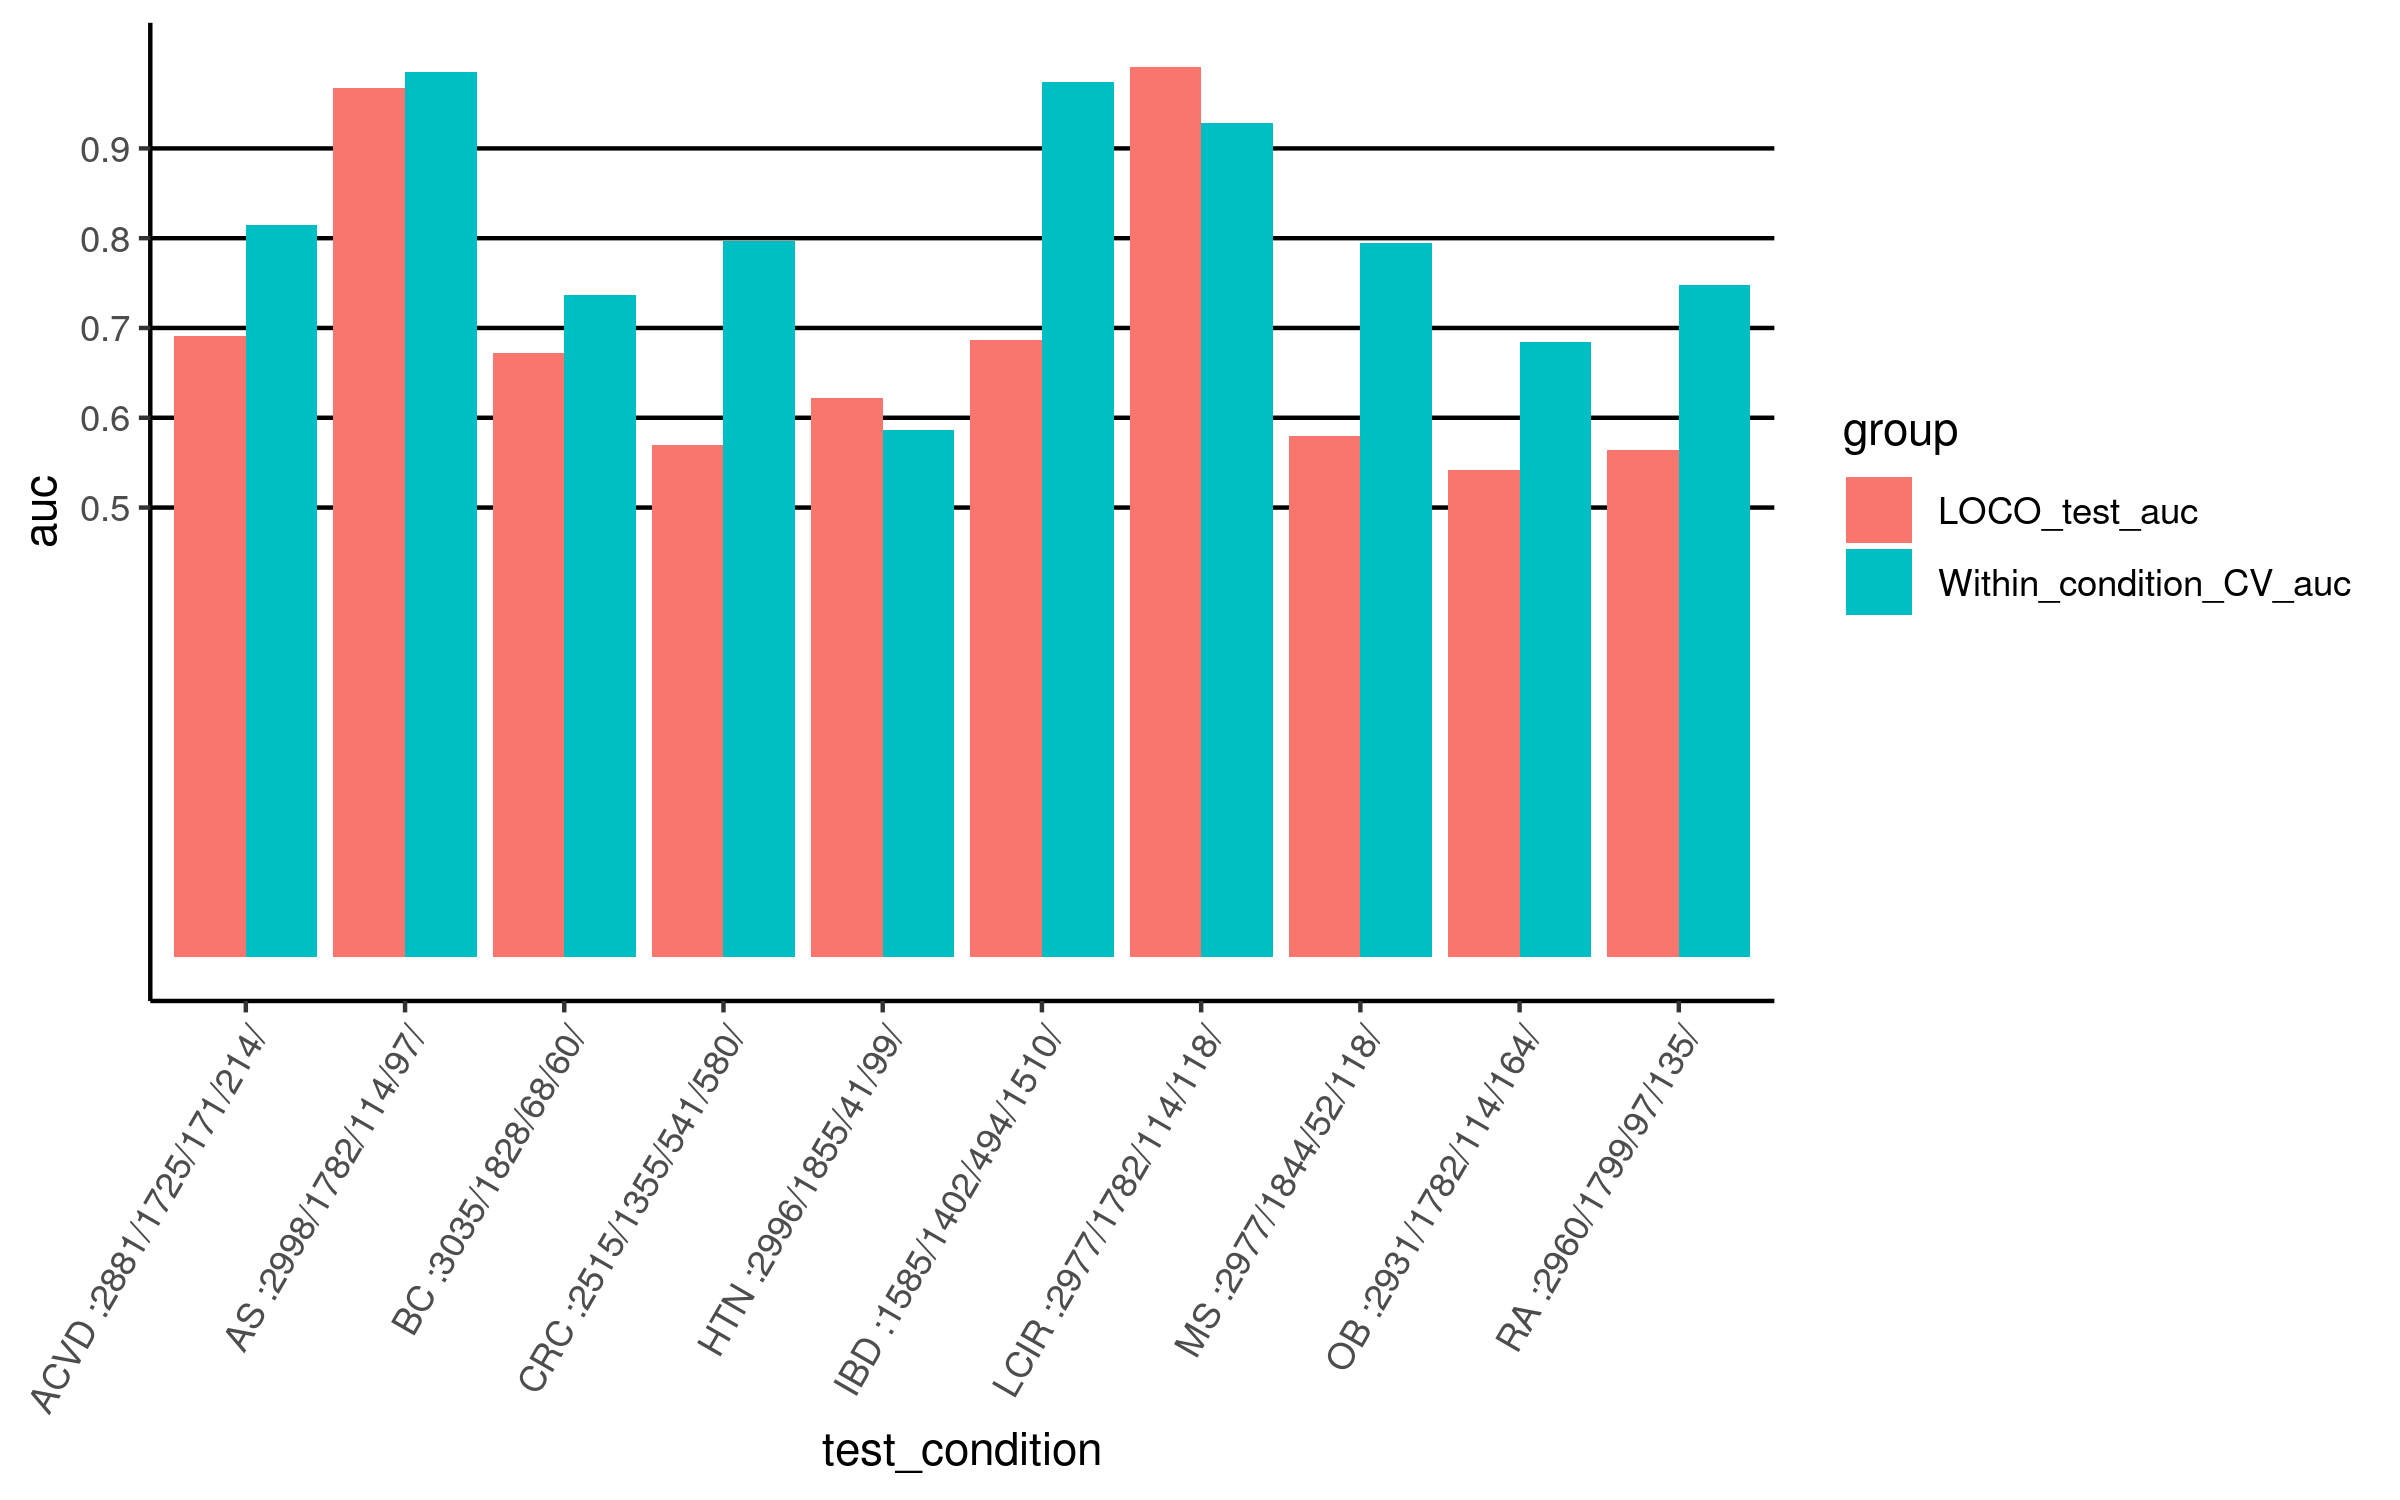

In [5]:
options(repr.plot.width = 8, repr.plot.height = 5, repr.plot.res = 300)
ggplot(data = data_out) +
theme_classic() +
geom_abline(slope = 0, intercept = 0.5) +
geom_abline(slope = 0, intercept = 0.6) +
geom_abline(slope = 0, intercept = 0.7) +
geom_abline(slope = 0, intercept = 0.8) +
geom_abline(slope = 0, intercept = 0.9) +
geom_bar(aes(x = test_condition, y = auc, fill = group), stat = 'identity', position = 'dodge') +
theme(axis.text.x = element_text(angle = 60, hjust = 1)) +
scale_y_continuous(breaks = c(0.5, 0.6, 0.7, 0.8, 0.9)) +
#geom_errorbar(aes(x = test_condition, y = mean_auc, ymin = mean_auc - sd_auc, ymax = mean_auc + sd_auc), width = 0.2)
NULL


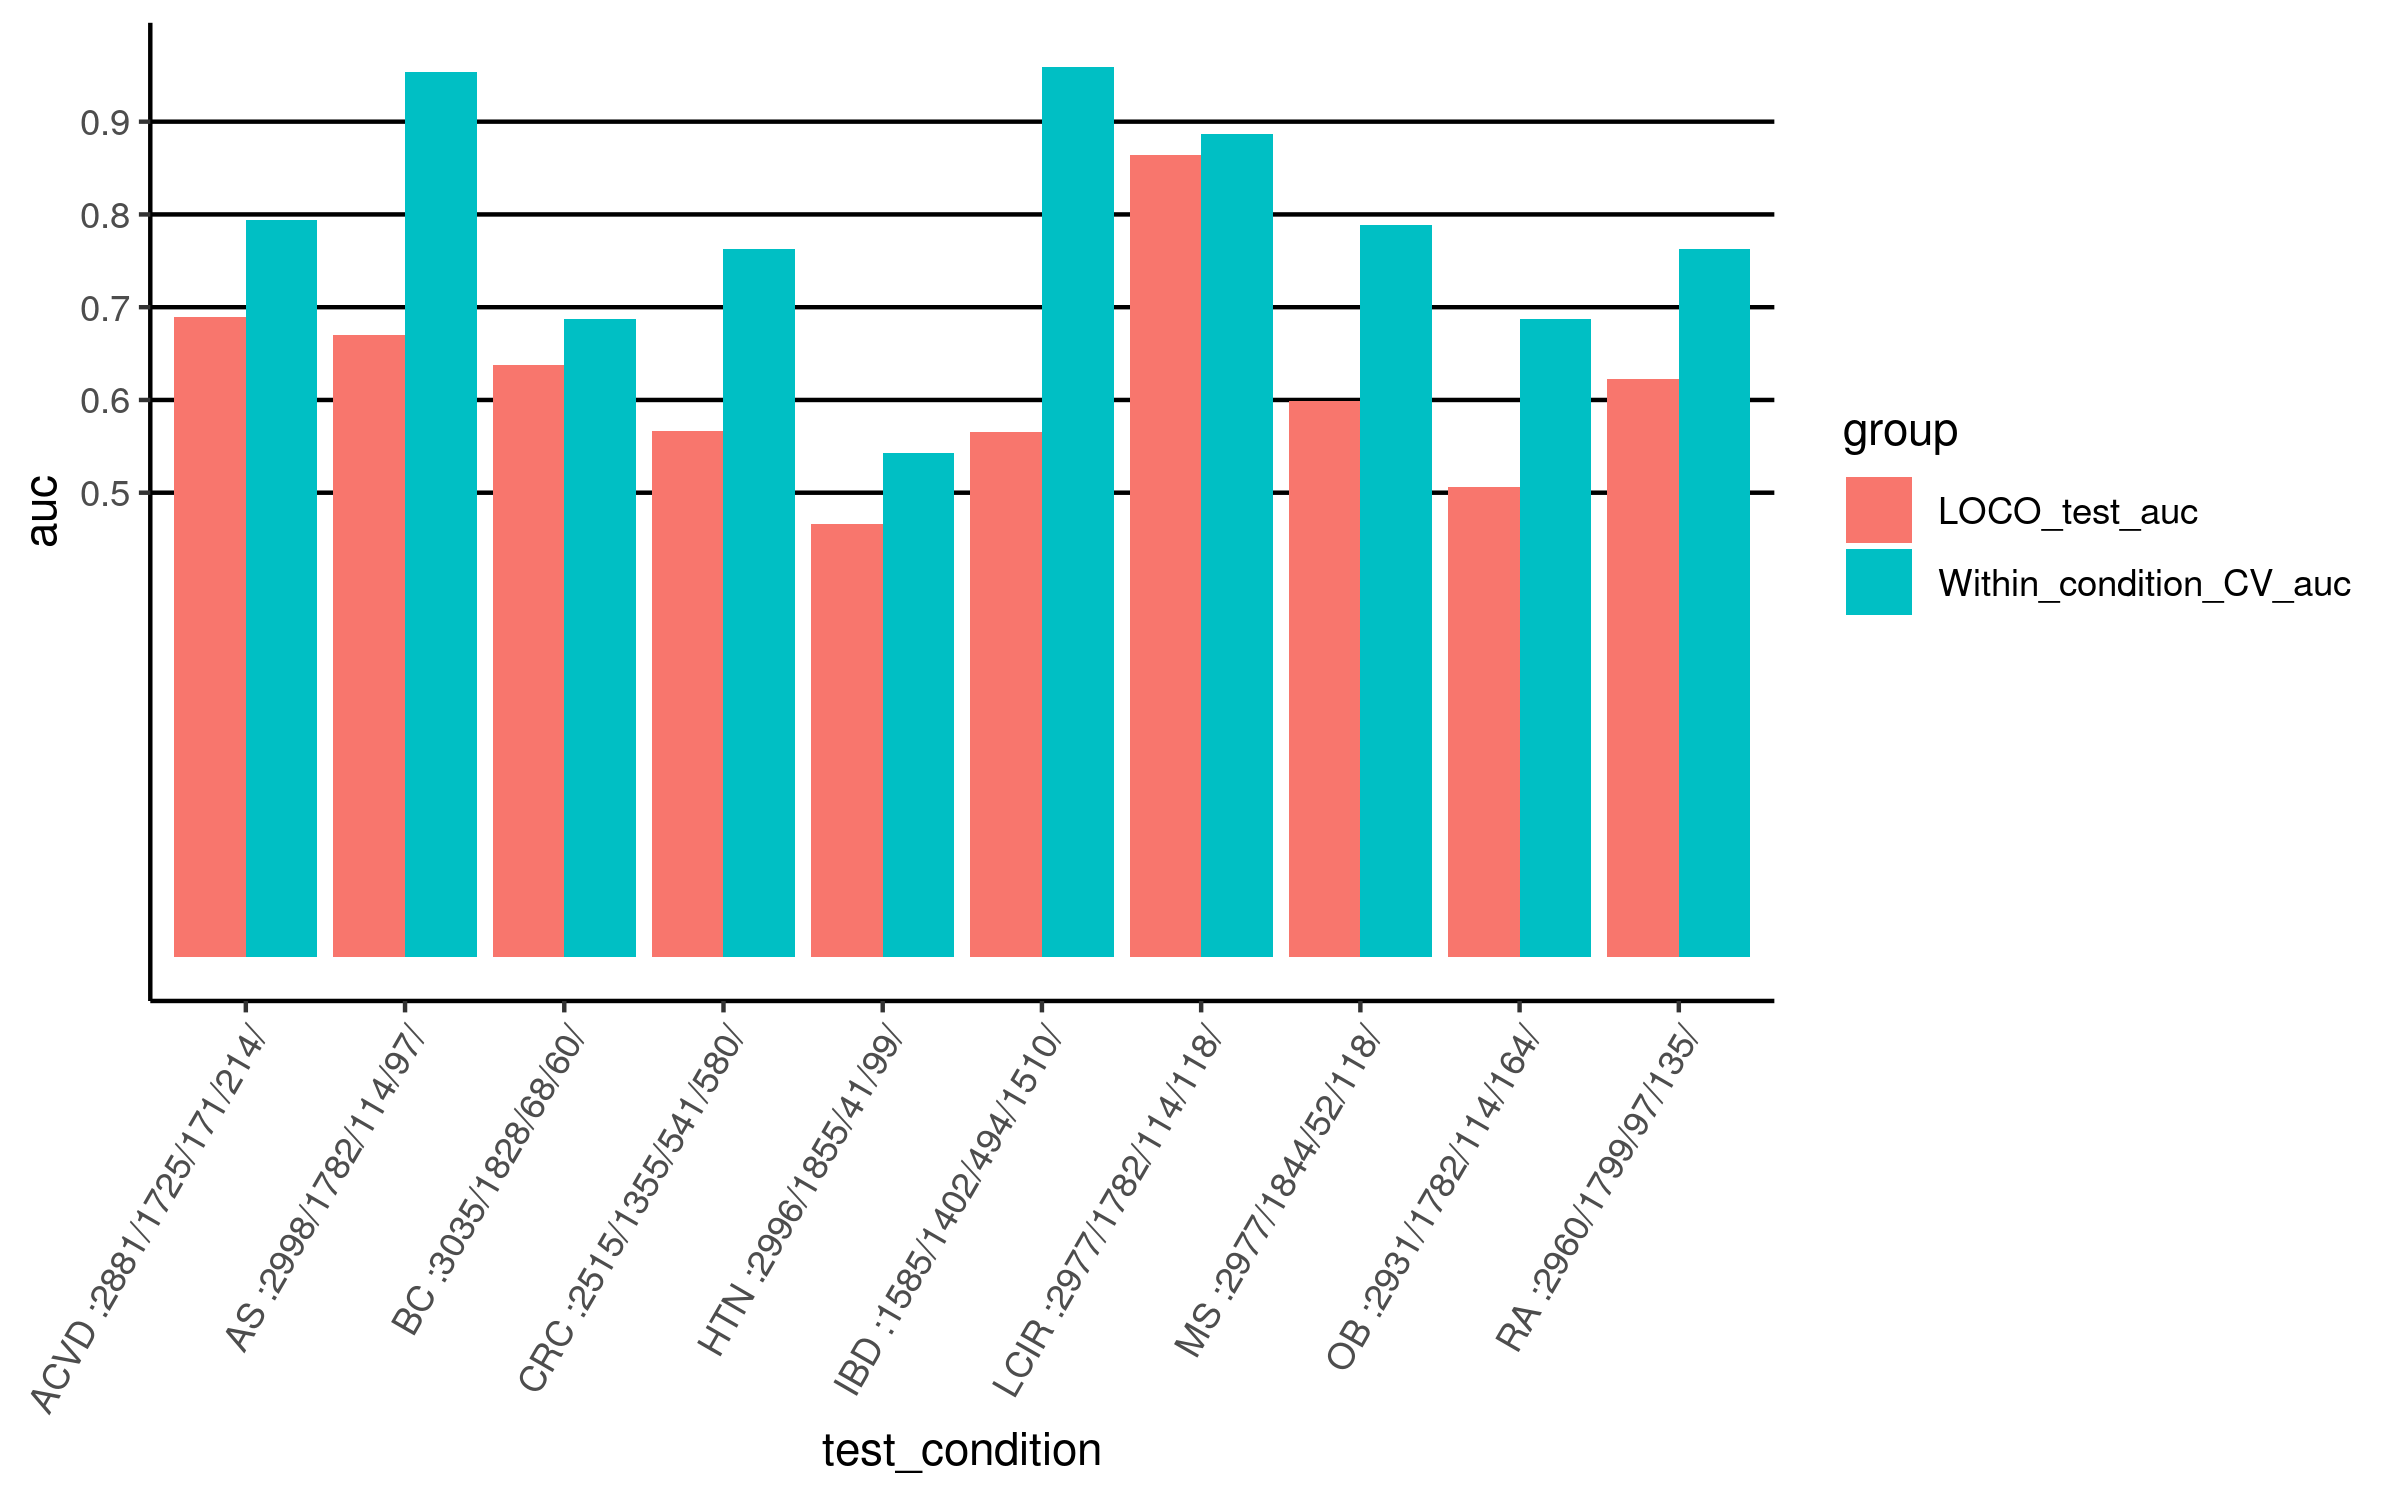

In [317]:
options(repr.plot.width = 8, repr.plot.height = 5, repr.plot.res = 300)
ggplot(data = data_out) +
theme_classic() +
geom_abline(slope = 0, intercept = 0.5) +
geom_abline(slope = 0, intercept = 0.6) +
geom_abline(slope = 0, intercept = 0.7) +
geom_abline(slope = 0, intercept = 0.8) +
geom_abline(slope = 0, intercept = 0.9) +
geom_bar(aes(x = test_condition, y = auc, fill = group), stat = 'identity', position = 'dodge') +
theme(axis.text.x = element_text(angle = 60, hjust = 1)) +
scale_y_continuous(breaks = c(0.5, 0.6, 0.7, 0.8, 0.9)) +
#geom_errorbar(aes(x = test_condition, y = mean_auc, ymin = mean_auc - sd_auc, ymax = mean_auc + sd_auc), width = 0.2)
NULL


## TODO

- Incoorporate the 16S profiles...

In [ ]:
# Duvallet...
system("ls  /g/zeller/jawirbel/siamcat_paper/duvallet_reproduction/microbiomeHD/data/clean_tables", intern=TRUE)